In [1]:
#use niwrap2912 conda environment
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore


In [2]:

global DO_ZSCORE_BEFORE_DIFF
DO_ZSCORE_BEFORE_DIFF = False
# Configuration
#for exvivo (bigbrain stuff is on the next cell!)
base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0/output_120um_max_960um_dist_method0'
workbench_base_path ='/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0'
manual_base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0'
output_dir = './figure'
hemi = 'lh'
fontsize = 8
percentil_low = 10
percentil_high = 70
cmap = 'inferno'
resolutions = ['120', '240']


if DO_ZSCORE_BEFORE_DIFF:
    data_types = ['raw', 'raw_zscore', 'diff', 'diff_before_zscore']
elif not DO_ZSCORE_BEFORE_DIFF:
    data_types = ['raw', 'raw_zscore', 'diff_after_zscore', 'diff_before_zscore']

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
print(f"Found {len(subject_folders)} subjects: {subject_folders}")

def load_and_process_data(file_path, sorted_order=None):
    """Load data and compute processed versions (diff, zscore)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Use provided sorted order or compute new one
    if sorted_order is None:
        sorted_order = np.argsort(np.nanmean(data['all_values'], axis=0))
    
    # Extract and sort raw values
    raw = data['all_values'][:, sorted_order]
    
    # Compute processed versions
    raw_zscore = zscore(raw, axis=0, nan_policy='omit')
    

    #take differentials before and after zscoring
    diff = (np.diff(raw, axis=0))
    diff_before_zscore = zscore(diff, axis=0, nan_policy='omit')#this is original
    #
    diff_after_zscore = (np.diff(raw_zscore, axis=0))

    
    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_after_zscore': diff_after_zscore,
        'diff_before_zscore': diff_before_zscore,
        'sorted_order': sorted_order,
        'data': data,
        
    }

def set_colorbar_limits(data, data_type):
    """Set appropriate colorbar limits based on data type."""
    if data_type == 'raw':
        return np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
    elif data_type in ['diff','diff_after_zscore', 'diff_before_zscore','raw_zscore']:
        p_low, p_high = np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
        #max_clim = round(max(abs(p_low), abs(p_high)), 2)
        return p_low, p_high

def setup_colorbar(im, ax, data_type, vmin, vmax):
    """Setup colorbar with appropriate ticks and labels."""
    cbar = plt.colorbar(im, ax=ax)
    
    #if data_type in ['diff', 'diff_after_zscore', 'diff_before_zscore']:
       # cbar.set_ticks([vmin, 0, vmax])
       # cbar.set_ticklabels([f'{vmin:.2f}', '0', f'{vmax:.2f}'])
    
    return cbar

def create_subplot(ax, data, title, data_type, plot_dist_values):
    """Create a single subplot with proper formatting."""
    masked_data = np.ma.masked_invalid(data)
    
    im = ax.imshow(masked_data, aspect='auto', 
                   # The 'extent' argument in imshow sets the axis limits and orientation.
                   # Here, x-axis goes from 0 to number of columns (vertices), 
                   # y-axis goes from the last to the first value in plot_dist_values (to flip y-axis so 0 is at the top).
                   #extent=[0, data.shape[1], plot_dist_values[-1], plot_dist_values[0]], 
                   cmap=cmap)
    #I need to set each ytick to the values in plot_dist_values
    ax.set_yticks(range(len(plot_dist_values)))
    # Set yticklabels for odd-numbered indices only
    yticklabels = [f"{np.round(val,2)}" if i % 2 == 1 else "" for i, val in enumerate(plot_dist_values)]
    ax.set_yticklabels(yticklabels)
    
    vmin, vmax = set_colorbar_limits(data, data_type)
    im.set_clim(vmin, vmax)
    
    setup_colorbar(im, ax, data_type, vmin, vmax)
    
    ax.set_xlabel('Vertices (ordered by column mean intensity)', fontsize=fontsize+1)
    ax.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+1,fontweight='bold')
    
    return im

# Process each subject
data_storage = {}
all_dist_values = {}
for subject_name in subject_folders:
    print(f"\nProcessing subject: {subject_name}")
    
    try:
        # Load and process data for all resolutions
        for resolution in resolutions:
            print(f"  Processing resolution: {resolution}")
            manual_path = f'{manual_base_path}/output_{resolution}um_max_960um_dist_method0/{subject_name}/{hemi}/inf_{resolution}um_method0_manual_raw_intensity.npz'
            
            if not os.path.exists(manual_path):
                print(f"    Warning: Manual file not found: {manual_path}")
                continue
            
            # Initialize data storage dictionaries for this subject
            if subject_name not in data_storage:
                data_storage[subject_name] = {}
            
            data_storage[subject_name][resolution] = {'manual': {}}
            
            # Load manual data first to establish sorting order
            manual_results = load_and_process_data(manual_path)
            sorted_order = manual_results['sorted_order']
            
            # Store processed data
            data_storage[subject_name][resolution]['manual'] = manual_results
            
            # Extract distance array
            all_dist_values[resolution] = manual_results['data']['dist_array']

        # Skip if no data was loaded
        if not all_dist_values:
            print(f"  Skipping {subject_name}: No data files found")
            continue
        
        # Use the first resolution's distance values for plotting
        plot_dist_values = all_dist_values[resolutions[0]]
        # Calculate the average between each pair of successive values in plot_dist_values
        if isinstance(plot_dist_values, (list, np.ndarray)) and len(plot_dist_values) > 1:
            avg_between_successive = [(plot_dist_values[i] + plot_dist_values[i+1]) / 2 for i in range(len(plot_dist_values)-1)]
            print("Averages between successive values in plot_dist_values:", avg_between_successive)
        else:
            print("plot_dist_values does not have enough elements to compute averages between successive values.")
        print(np.array(avg_between_successive))

        # Create individual figures for each data type
        individual_figures = []
        for data_type in data_types:
            print(f"  Creating plots for data type: {data_type}")
            
            # Get data for both resolutions
            data1_manual = data_storage[subject_name][resolutions[0]]['manual'][data_type]
            data2_manual = data_storage[subject_name][resolutions[1]]['manual'][data_type]
            
            # Create figure with subplots
            #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3))
            
            # Create subplots
            #create_subplot(ax1, data1_manual, '120um', data_type, plot_dist_values)
            #create_subplot(ax2, data2_manual, '240um', data_type, plot_dist_values)
            
            fig, (ax1) = plt.subplots(1, 1, figsize=(6,2))
            # Create subplots
            if data_type == 'raw' or data_type == 'raw_zscore':
                create_subplot(ax1, data1_manual, '120um', data_type, plot_dist_values)
            else:
                #for differences    
                create_subplot(ax1, data1_manual, '120um', data_type, avg_between_successive)

            # Add tight layout
            plt.tight_layout()
            
            # Save individual figure
            individual_figures.append(fig)
            plt.close(fig)
        
        # Create combined 2x2 figure

        combined_fig, axes = plt.subplots(2, 2, figsize=(4,2),dpi=300)
        axes = axes.flatten()
        
        # Add supertitle for the subject
        combined_fig.suptitle(f'{subject_name}', fontsize=fontsize-2, fontweight='bold', y=0.98)

        # Copy each individual figure to the combined figure
        for i, (data_type, individual_fig) in enumerate(zip(data_types, individual_figures)):
            # Get the individual figure's canvas as an image
            individual_fig.canvas.draw()
            buf = np.frombuffer(individual_fig.canvas.buffer_rgba(), dtype=np.uint8)
            buf = buf.reshape(individual_fig.canvas.get_width_height()[::-1] + (4,))
            buf = buf[:, :, :3]  # Remove alpha channel
            
            # Display in the combined figure
            axes[i].imshow(buf)
            axes[i].set_title(f'{data_type}', fontsize=fontsize-4, fontweight='bold')
            axes[i].axis('off')
        
        # Adjust layout and save combined figure
        plt.tight_layout()
        output_path = os.path.join(output_dir, hemi)
        #create the folder if it doesn't exist
        os.makedirs(output_path, exist_ok=True)
        if DO_ZSCORE_BEFORE_DIFF:
            #plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_{subject_name}_zscore_before_diff.png'), dpi=300, bbox_inches='tight')
            plt.savefig(os.path.join(output_path,f'combined_comparison_120um_{subject_name}_zscore_before_diff.png'), dpi=300, bbox_inches='tight')
        else:
            #plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_{subject_name}_zscore_after_diff.png'), dpi=300, bbox_inches='tight')
            plt.savefig(os.path.join(output_path,f'combined_comparison_120um_{subject_name}_zscore_after_diff.png'), dpi=300, bbox_inches='tight')
        plt.close(combined_fig)
        print(f"  Saved figure: {output_path}")
        
        # Close individual figures to free memory
        for fig in individual_figures:
            plt.close(fig)
        
    except Exception as e:
        print(f"  Error processing {subject_name}: {str(e)}")
        continue

print(f"\nProcessing complete! Figures saved in {output_dir}")

Found 17 subjects: ['I57_new_confidence', 'I58_new_confidence', 'I45_new_confidence', 'I59_new_confidence', 'I56_new_confidence', 'I41_new_confidence', 'I54_new_confidence', 'I38_new_confidence', 'I53_new_confidence', 'I46_new_confidence', 'EXC022_new_confidence', 'I52_new_confidence', 'I48_new_confidence', 'I55_new_confidence', 'I61_new_confidence', 'KC001_new_confidence', 'I60_new_confidence']

Processing subject: I57_new_confidence
  Processing resolution: 120
  Processing resolution: 240
Averages between successive values in plot_dist_values: [np.float64(0.84), np.float64(0.72), np.float64(0.6), np.float64(0.48), np.float64(0.36), np.float64(0.24), np.float64(0.12), np.float64(0.0), np.float64(-0.12), np.float64(-0.24), np.float64(-0.36), np.float64(-0.48), np.float64(-0.6), np.float64(-0.72), np.float64(-0.84)]
[ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]
  Creating plots for data type: raw
  Creating plots for data type: raw_zscore


[[ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]


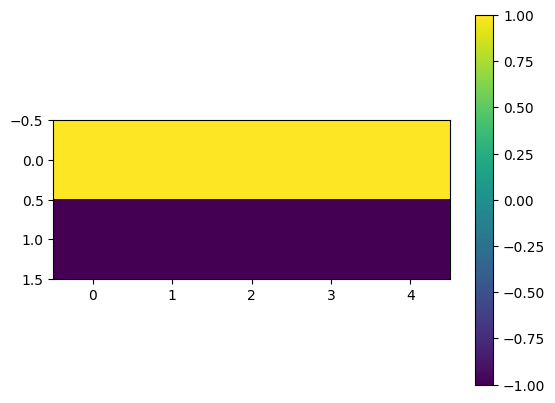

In [3]:
# Example of correct np.diff usage: subtracting two arrays elementwise

# Print a 2D list (matrix) without numpy
matrix = [[1, 2,3,4,5], [2, 3,4,5,6 ],[1,2,3,4,5]]
print(np.diff(matrix,axis=0))
plt.imshow(np.diff(matrix,axis=0))
plt.colorbar()
plt.show()


  Processing resolution: 120
shape (16, 163842)
[[10293.96323746  2187.80830526   275.10199134 ... 65535.
  65535.         65535.        ]
 [ 2805.97111911  1376.86608273   157.93745263 ... 65535.
  65535.         65535.        ]
 [  391.84860603   631.05949896   242.26692442 ... 65535.
  65535.         65535.        ]
 ...
 [ 3405.00523308  7264.39403965  8592.4736231  ... 65535.
  65535.         65535.        ]
 [ 3716.02377126  2602.84602104  2168.7407511  ... 65535.
  65535.         65535.        ]
 [ 1620.85561208  1524.16422748  1809.69204923 ... 65535.
  65535.         65535.        ]]
[ 0.9   0.78  0.66  0.54  0.42  0.3   0.18  0.06 -0.06 -0.18 -0.3  -0.42
 -0.54 -0.66 -0.78 -0.9 ]
  Processing resolution: 240
shape (8, 163842)
[[ 6296.88526258  2839.72766652   516.14063069 ... 65535.
  65535.         65535.        ]
 [  399.23667319   503.7784385    991.6276874  ... 65535.
  65535.         65535.        ]
 [  169.09496621   129.90623932   529.46688665 ... 65535.
  65535.      

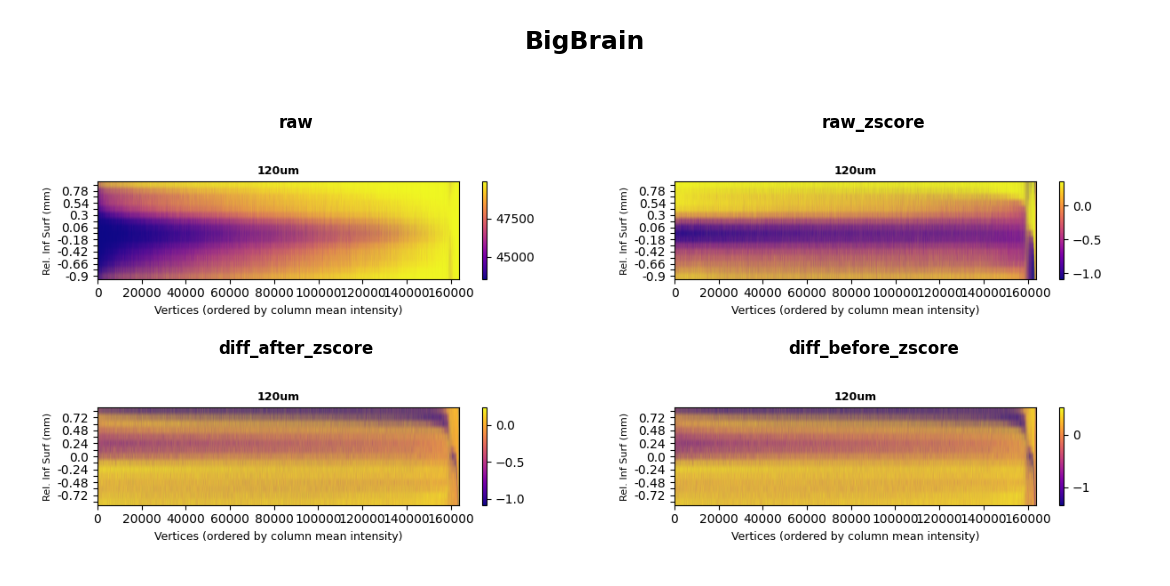

In [4]:
#for bigbrain
# Configuration
hemi = 'lh'
fontsize = 8
percentil_low = 10
percentil_high = 70
cmap = 'plasma'
resolutions = ['120', '240']

if DO_ZSCORE_BEFORE_DIFF:
    data_types = ['raw', 'raw_zscore', 'diff', 'diff_before_zscore']
elif not DO_ZSCORE_BEFORE_DIFF:
    data_types = ['raw', 'raw_zscore', 'diff_after_zscore', 'diff_before_zscore']

subject_name = 'BigBrain'
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def load_and_process_data(file_path, sorted_order=None):
    """Load data and compute processed versions (diff, zscore) with NaN handling."""
    data = np.load(file_path, allow_pickle=True)
    
    # Use provided sorted order or compute new one
    if sorted_order is None:
        # Use nanmean for sorting to handle NaN values
        sorted_order = np.argsort(np.nanmean(data['all_values'], axis=0))
    
    # Extract and sort raw values
    raw = data['all_values'][:, sorted_order]
    print('shape',raw.shape)
    print(raw)

    # Compute processed versions with NaN handling
    # For zscore, use nanmean and nanstd
    raw_mean = np.nanmean(raw, axis=0, keepdims=True)
    raw_std = np.nanstd(raw, axis=0, keepdims=True)
    raw_std[raw_std == 0] = 1  # Avoid division by zero
    raw_zscore = (raw - raw_mean) / raw_std  # Yes, this is z-score normalization
    #import zscore from scipy.stats
    #raw_zscore = zscore(raw, axis=0, nan_policy='omit')
    # For diff, use np.diff which preserves NaN values
     #take differentials before and after zscoring
    diff = (np.diff(raw, axis=0))
    diff_before_zscore = zscore(diff, axis=0, nan_policy='omit')#this is original

    #
    diff_after_zscore = (np.diff(raw_zscore, axis=0))

    #get sign only
   # diff_before_zscore = np.sign(diff_before_zscore)
    #diff_after_zscore = np.sign(diff_after_zscore)
    #END 10/01/2025
 

    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_after_zscore': diff_after_zscore,
        'diff_before_zscore': diff_before_zscore,
        'sorted_order': sorted_order,
        'data': data,
        
    }
    

def set_colorbar_limits(data, data_type):
    """Set appropriate colorbar limits based on data type with NaN handling."""
    # Use nanpercentile to handle NaN values
    if data_type == 'raw':
        return np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
    elif data_type in ['diff','diff_after_zscore', 'diff_before_zscore','raw_zscore']:
        p_low, p_high = np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
        #max_clim = round(max(abs(p_low), abs(p_high)), 2)
        return p_low, p_high

def setup_colorbar(im, ax, data_type, vmin, vmax):
    """Setup colorbar with appropriate ticks and labels."""
    cbar = plt.colorbar(im, ax=ax)
    
    return cbar

def create_subplot(ax, data, title, data_type, plot_dist_values):
    """Create a single subplot with proper formatting and NaN handling."""
    # Create masked array to handle NaN values in visualization
    masked_data = np.ma.masked_invalid(data)
    
    
    im = ax.imshow(masked_data, aspect='auto', 
                   # The 'extent' argument in imshow sets the axis limits and orientation.
                   # Here, x-axis goes from 0 to number of columns (vertices), 
                   # y-axis goes from the last to the first value in plot_dist_values (to flip y-axis so 0 is at the top).
                   #extent=[0, data.shape[1], plot_dist_values[-1], plot_dist_values[0]], 
                   cmap=cmap)
    #I need to set each ytick to the values in plot_dist_values
    ax.set_yticks(range(len(plot_dist_values)))
    # Set yticklabels for odd-numbered indices only
    yticklabels = [f"{np.round(val,2)}" if i % 2 == 1 else "" for i, val in enumerate(plot_dist_values)]
    ax.set_yticklabels(yticklabels)
    vmin, vmax = set_colorbar_limits(data, data_type)
    
    # Handle case where vmin or vmax might be NaN
    if np.isnan(vmin) or np.isnan(vmax):
        print(f"Warning: NaN values in colorbar limits for {title}, using data min/max")
        vmin, vmax = np.nanmin(data), np.nanmax(data)
    
    print('vmin',vmin,'vmax',vmax)
    im.set_clim(vmin, vmax)
    
    setup_colorbar(im, ax, data_type, vmin, vmax)
    
    ax.set_xlabel('Vertices (ordered by column mean intensity)', fontsize=fontsize+1)
    ax.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+1,fontweight='bold')
    
    return im

# Process each subject


# Load and process data for all resolutions
for resolution in resolutions:
    print(f"  Processing resolution: {resolution}")
    
    # Define file paths
    manual_path = f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/at_inf_surface/bigbrain_{hemi}_layer3_{resolution}um_max_960um_method0_manual_raw_intensity.npz'
    #workbench_path = f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/{resolution}um_method1/bigbrain_workbench_raw_intensity.npz'

    # Initialize data storage dictionaries for this subject
    # Initialize data storage dictionaries for this subject
    if subject_name not in data_storage:
        data_storage[subject_name] = {}
            
    data_storage[subject_name][resolution] = {
        'manual': {}
       # 'workbench': {}
    }
    
    # Check if files exist
    #if not os.path.exists(workbench_path):
    #    print(f"    Warning: Workbench file not found: {workbench_path}")
    #    continue
    if not os.path.exists(manual_path):
        print(f"    Warning: Manual file not found: {manual_path}")
        continue
    
    # Load manual data first to establish sorting order
    manual_results = load_and_process_data(manual_path)
    
    # Load workbench data using the same sorting order
    #workbench_results = load_and_process_data(workbench_path)
    # Store processed data
    data_storage[subject_name][resolution]['manual']= manual_results
    #data_storage[subject_name][resolution]['workbench'] = workbench_results
    
    # Extract distance array
    all_dist_values[resolution] = manual_results['data']['dist_array']
    print(all_dist_values[resolution])



# Use the first resolution's distance values for plotting
plot_dist_values = all_dist_values[resolutions[0]]


# Calculate the average between each pair of successive values in plot_dist_values
if isinstance(plot_dist_values, (list, np.ndarray)) and len(plot_dist_values) > 1:
    avg_between_successive = [(plot_dist_values[i] + plot_dist_values[i+1]) / 2 for i in range(len(plot_dist_values)-1)]
    print("Averages between successive values in plot_dist_values:", avg_between_successive)
else:
    print("plot_dist_values does not have enough elements to compute averages between successive values.")
print(np.array(avg_between_successive))

# Create individual figures for each data type
individual_figures = []
for data_type in data_types:
    print(f"  Creating plots for data type: {data_type}")
    
    # Get data for both resolutions
    data1_manual = data_storage[subject_name]['120']['manual'][data_type]
    data2_manual = data_storage[subject_name]['240']['manual'][data_type]
    
    # Check for NaN values and reports
    nan_count_1 = np.sum(np.isnan(data1_manual))
    nan_count_2 = np.sum(np.isnan(data2_manual))
    if nan_count_1 > 0 or nan_count_2 > 0:
        print(f"    Warning: Found {nan_count_1} NaN values in 120um data, {nan_count_2} NaN values in 240um data")
    
    
    # Create figure with subplots
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3))
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))
    # Create subplots
    if data_type == 'raw' or data_type == 'raw_zscore':
        create_subplot(ax1, data1_manual, '120um', data_type, plot_dist_values)
    else:
        #for differences    
        create_subplot(ax1, data1_manual, '120um', data_type, avg_between_successive)

    #

    # Add tight layout
    plt.tight_layout()
    
    # Save individual figure
    individual_figures.append(fig)
    plt.close(fig)

# Create combined 2x2 figure
combined_fig, axes = plt.subplots(2, 2, figsize=(4,2),dpi=300)
axes = axes.flatten()

# Add supertitle for the subject
combined_fig.suptitle(f'{subject_name}', fontsize=fontsize-2, fontweight='bold', y=0.98)

# Copy each individual figure to the combined figure
for i, (data_type, individual_fig) in enumerate(zip(data_types, individual_figures)):
    # Get the individual figure's canvas as an image
    individual_fig.canvas.draw()
    buf = np.frombuffer(individual_fig.canvas.buffer_rgba(), dtype=np.uint8)
    buf = buf.reshape(individual_fig.canvas.get_width_height()[::-1] + (4,))
    buf = buf[:, :, :3]  # Remove alpha channel
    
    # Display in the combined figure
    axes[i].imshow(buf)
    axes[i].set_title(f'{data_type}', fontsize=fontsize-4, fontweight='bold')
    axes[i].axis('off')

# Adjust layout and save combined figure with extra space for supertitle
plt.tight_layout(rect=[0, 0, 1, 1])
output_path = os.path.join(output_dir, hemi)
#create the folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)
if DO_ZSCORE_BEFORE_DIFF:
    #plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_bigbrain_zscore_before_diff.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(output_path,f'combined_comparison_120um_bigbrain_zscore_before_diff.png'), dpi=300, bbox_inches='tight')
else:
   # plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_bigbrain_zscore_after_diff.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(output_path,f'combined_comparison_120um_bigbrain_zscore_after_diff.png'), dpi=300, bbox_inches='tight')
#plt.close(combined_fig)
print(f"  Saved figure: {output_path}")

# Close individual figures to free memory
for fig in individual_figures:
    plt.close(fig)
    
   

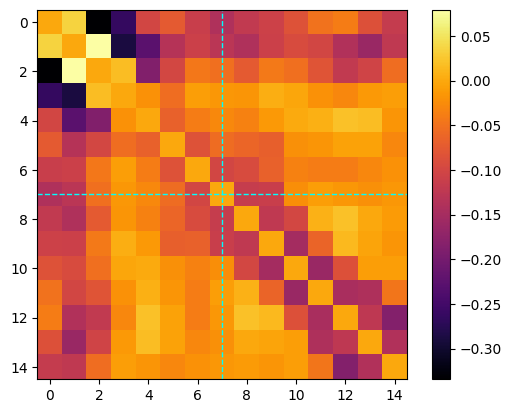

In [5]:
tmp = (data_storage['BigBrain']['120']['manual']['diff_before_zscore']);
#let's do correlation between all pairs of columns in tmp
correlations = np.corrcoef(tmp)
#set diaognals to 0
np.fill_diagonal(correlations, 0)
plt.imshow(correlations,cmap='inferno')
plt.colorbar()

plt.axhline(7, color='cyan', linestyle='--', linewidth=1)
plt.axvline(7, color='cyan', linestyle='--', linewidth=1)


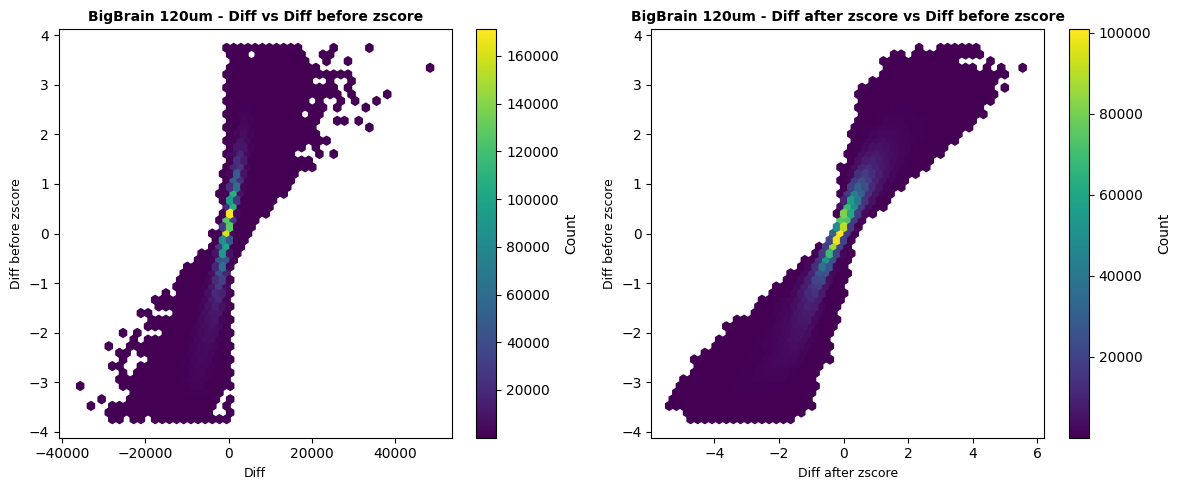

In [6]:
# do scatter plot of diff vs diff_before_zscore
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
im1 = axes[0].hexbin(data_storage['BigBrain']['120']['manual']['diff'], data_storage['BigBrain']['120']['manual']['diff_before_zscore'], gridsize=50, cmap='viridis', mincnt=0.1)
axes[0].set_xlabel('Diff',fontsize=fontsize+1)
axes[0].set_ylabel('Diff before zscore',fontsize=fontsize+1)
axes[0].set_title('BigBrain 120um - Diff vs Diff before zscore', fontsize=fontsize+2,fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Count')

# Second subplot
im2 = axes[1].hexbin(data_storage['BigBrain']['120']['manual']['diff_after_zscore'], data_storage['BigBrain']['120']['manual']['diff_before_zscore'], gridsize=50, cmap='viridis', mincnt=0.1)
axes[1].set_xlabel('Diff after zscore',fontsize=fontsize+1)
axes[1].set_ylabel('Diff before zscore',fontsize=fontsize+1)
axes[1].set_title('BigBrain 120um - Diff after zscore vs Diff before zscore', fontsize=fontsize+2,fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Count')

plt.tight_layout()
plt.show()


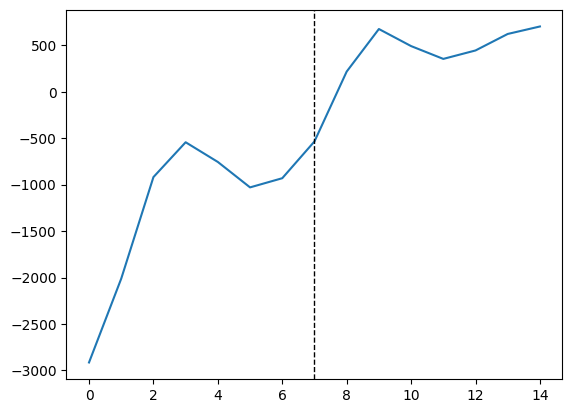

In [8]:

plt.plot(np.diff(np.mean(data_storage['BigBrain']['120']['manual']['raw'],axis=1)))
plt.axvline(7, color='k', linestyle='--', linewidth=1)
plt.show()

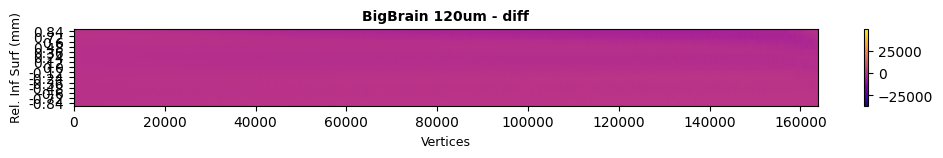

In [9]:

DATA_TYPE = 'diff'
CMAP = 'plasma'
plt.figure(figsize=(12,1))
data2plot = (data_storage['BigBrain']['120']['manual'][DATA_TYPE])
#sort by column mean vlaue of data2plot
# Sort columns by their range (max - min, ignoring NaNs)
col_range = np.nanmax(data2plot, axis=0) - np.nanmin(data2plot, axis=0)
sorted_data2plot = data2plot[:, np.argsort(col_range)]
plt.imshow(sorted_data2plot,aspect='auto',cmap=CMAP)
plt.title(f'BigBrain 120um - {DATA_TYPE}', fontsize=fontsize+2,fontweight='bold')
plt.xlabel('Vertices',fontsize=fontsize+1)
plt.ylabel('Rel. Inf Surf (mm)',fontsize=fontsize+1)
#plt.clim(np.nanpercentile(data_storage['BigBrain']['120']['manual'][DATA_TYPE],20),np.nanpercentile(data_storage['BigBrain']['120']['manual'][DATA_TYPE],80))
min_val = np.nanpercentile(data_storage['BigBrain']['120']['manual'][DATA_TYPE],10)
max_val = np.nanpercentile(data_storage['BigBrain']['120']['manual'][DATA_TYPE],70)
#fine the min of the two
min_val = max(np.abs(min_val),np.abs(max_val))
#plt.clim(-1,1)
#put yticks at the values of plot_dist_values
#calculate mean of every 2 values in plot_dist_values
# Check if plot_dist_values is a scalar or array
if np.isscalar(plot_dist_values):
    dist_values_inbetween = plot_dist_values
else:
    dist_values_inbetween = np.array([(plot_dist_values[i] + plot_dist_values[i+1]) / 2 for i in range(len(plot_dist_values)-1)])
plt.yticks(range(len(dist_values_inbetween)), np.round(dist_values_inbetween,2))

plt.colorbar()
plt.show()


In [10]:
print(min_val,max_val)

3122.501720463832 665.1800779438267


In [11]:
#use niwrap2912 conda environment
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

# Configuration
#for exvivo (bigbrain stuff is on the next cell!)
base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method0'
workbench_base_path ='/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'
manual_base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'

# BigBrain configuration
bigbrain_base_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii'
bigbrain_output_dir = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/output'

output_dir = './figure'
hemi = 'lh'
fontsize = 8
percentil_low = 20
percentil_high = 80
cmap = 'plasma'
resolutions = ['120', '240']
data_types = ['raw', 'raw_zscore', 'diff', 'diff_zscore']

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
print(f"Found {len(subject_folders)} subjects: {subject_folders}")

def load_and_process_data(file_path):
    """Load data and compute processed versions (diff, zscore)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Extract raw values without sorting
    raw = data['all_values']
    
    # Compute processed versions
    raw_zscore = zscore(raw, axis=0, nan_policy='omit')
    
    diff = np.diff(raw, axis=0)
    diff_zscore = zscore(diff, axis=0, nan_policy='omit')
    
    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_zscore': diff_zscore,
        'data': data
    }

def load_bigbrain_data():
    """Load BigBrain data for comparison."""
    bigbrain_data = {}
    
    # Define BigBrain resolution mapping
    bigbrain_resolutions = {
        '120': '120um',
        '240': '240um'
    }
    
    #f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_{hemi}_layer3_{resolution}um_method1_manual_raw_intensity.npz'
    for resolution in resolutions:
        bb_resolution = bigbrain_resolutions[resolution]
        bb_file_path = os.path.join(bigbrain_base_path, f'bigbrain_{hemi}_layer3_{bb_resolution}_method1_manual_raw_intensity.npz')
        
        if os.path.exists(bb_file_path):
            print(f"Loading BigBrain data: {bb_file_path}")
            bb_results = load_and_process_data(bb_file_path)
            bigbrain_data[resolution] = {'bigbrain': bb_results}
        else:
            print(f"BigBrain file not found: {bb_file_path}")
    
    return bigbrain_data

# Process each subject and store data for analysis
data_storage = {}
all_dist_values = {}

for subject_name in subject_folders:
    print(f"\nProcessing subject: {subject_name}")
    
    try:
        # Load and process data for all resolutions
        for resolution in resolutions:
            print(f"  Processing resolution: {resolution}")
            manual_path = f'{manual_base_path}/output_{resolution}um_max_960um_dist_method0/{subject_name}/{hemi}/inf_{resolution}um_method0_manual_raw_intensity.npz'
            
            if not os.path.exists(manual_path):
                print(f"    Warning: Manual file not found: {manual_path}")
                continue
            
            # Initialize data storage dictionaries for this subject
            if subject_name not in data_storage:
                data_storage[subject_name] = {}
            
            data_storage[subject_name][resolution] = {'manual': {}}
            
            # Load manual data
            manual_results = load_and_process_data(manual_path)
            
            # Store processed data
            data_storage[subject_name][resolution]['manual'] = manual_results
            
            # Extract distance array
            all_dist_values[resolution] = manual_results['data']['dist_array']

        # Skip if no data was loaded
        if not all_dist_values:
            print(f"  Skipping {subject_name}: No data files found")
            continue
            
        print(f"  Successfully stored data for {subject_name}")
        
    except Exception as e:
        print(f"  Error processing {subject_name}: {str(e)}")
        continue

# Load BigBrain data
print("\nLoading BigBrain data...")
bigbrain_data = load_bigbrain_data()

# Add BigBrain data to data_storage for comparison
#if bigbrain_data:
#    data_storage['BigBrain'] = bigbrain_data
#    print(f"Successfully loaded BigBrain data for resolutions: {list(bigbrain_data.keys())}")

print(f"\nData loading complete! Stored data for {len(data_storage)} subjects")
print(f"Available subjects: {list(data_storage.keys())}")
print(f"Available resolutions: {resolutions}")
print(f"Available data types: {data_types}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method0'

In [ ]:
# %% PCA Analysis Functions

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RESOLUTION = '120'
def perform_pca_analysis(data, plot_variance=False):
    """
    Perform PCA analysis on input data
    
    Parameters:
    -----------
    data : array-like
        Input data to perform PCA on
    plot_variance : bool
        Whether to plot explained variance ratio
        
    Returns:
    --------
    dict : Dictionary containing PCA results
        - 'pca_model': fitted PCA model
        - 'transformed_data': PCA-transformed data
        - 'explained_variance_ratio': explained variance ratio for each component
        - 'cumulative_variance': cumulative explained variance
    """
    # Convert to numpy array and handle NaN values
    data_array = np.array(data)
    data_array[np.isnan(data_array)] = 0
    
    # Fit PCA (without standardization to preserve original scale)
    pca_model = PCA()
    transformed_data = pca_model.fit_transform(data_array)
    
    # Calculate variance metrics
    explained_variance_ratio = pca_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Print results
    print(f"Data shape: {data_array.shape}")
    print(f"First 5 components explain {cumulative_variance[4]:.3f} of variance")
    print(f"PC1 explains {explained_variance_ratio[0]:.3f} of variance")
    
    # Plot if requested
    if plot_variance:
        plt.figure(figsize=(8, 5))
        plt.plot(explained_variance_ratio[:10], 'o-')  # Show first 10 components
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('PCA Explained Variance Ratio')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'pca_model': pca_model,
        'transformed_data': transformed_data,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance
    }

def reconstruct_from_pc(pca_model, transformed_data, pc_indices=[0]):
    """
    Reconstruct data using specified principal components
    
    Parameters:
    -----------
    pca_model : sklearn PCA object
        Fitted PCA model
    transformed_data : array-like
        PCA-transformed data
    pc_indices : list
        List of PC indices to use for reconstruction (default: [0] for first PC only)
        
    Returns:
    --------
    tuple : (reconstructed_data, pc_scores, pc_loadings)
    """
    # Get scores and loadings for selected PCs
    pc_scores = transformed_data[:, pc_indices]
    pc_loadings = pca_model.components_[pc_indices, :]
    
    # Reconstruct in original space
    if len(pc_indices) == 1:
        reconstructed_data = np.outer(pc_scores.flatten(), pc_loadings.flatten()) + pca_model.mean_
    else:
        reconstructed_data = np.dot(pc_scores, pc_loadings) + pca_model.mean_
    
    return reconstructed_data, pc_scores, pc_loadings

# %% Run PCA Analysis on All Subjects

def run_pca_on_all_subjects(data_storage, resolution='240'):
    """
    Run PCA analysis on all subjects in data_storage
    
    Parameters:
    -----------
    data_storage : dict
        Dictionary containing subject data
    resolution : str
        Resolution to analyze ('120' or '240')
        
    Returns:
    --------
    tuple : (all_pca_results, all_var_explained)
    """
    all_pca_results = {}
    all_var_explained = {}
    
    print(f"Running PCA analysis for {resolution}um resolution...")
    
    for subject_name in data_storage.keys():
        print(f"Processing {subject_name}...")
        
        # Get data for PCA
        data_to_pca = data_storage[subject_name][resolution]['manual']['diff_zscore']
        
        # Perform PCA
        pca_results = perform_pca_analysis(data_to_pca)
        
        # Get PC1 scores - this is the key part to check!
        reconstructed_data, pc1_scores, pc1_loadings = reconstruct_from_pc(
            pca_results['pca_model'], 
            pca_results['transformed_data']
        )
        
        # Debug: Check what we're actually storing
        print(f"  PC1 scores shape: {pc1_scores.shape}")
        print(f"  PC1 scores type: {type(pc1_scores)}")
        print(f"  PC1 scores first 5 values: {pc1_scores.flatten()[:5]}")
        
        # Store PC1 scores (flattened to 1D array)
        all_pca_results[subject_name] = pc1_scores.flatten()
        all_var_explained[subject_name] = pca_results['explained_variance_ratio']
    
    return all_pca_results, all_var_explained


def plot_depth_intensity_1d(data, dist_array, label, xlabel=None, ylabel=None, ax=None, color=None):
    """Plot depth intensity profile with clean styling"""
    # Debug: Check what data we're plotting
    print(f"  Plotting data shape: {np.array(data).shape}")
    print(f"  Data type: {type(data)}")
    print(f"  First 5 values: {np.array(data).flatten()[:5]}")
    
    # Handle 1D data properly
    if len(np.array(data).shape) == 1:
        data_mean = np.array(data)
        data_std = np.zeros_like(data_mean)  # No std for single profile
        data_sem = data_std
    else:
        data_mean = np.nanmean(data, axis=1)
        data_std = np.nanstd(data, axis=1)
        data_sem = data_std
    
    if ax is None:
        plt.figure(figsize=(4, 6))
        ax = plt.gca()
    
    dist_adj = abs(dist_array[0] - dist_array[1]) / 2
    
    # Plot with clean styling
    line = ax.plot(data_mean, dist_array[1:] + dist_adj, 
                   label=label, linewidth=1.5, color=color)
    
    # Subtle confidence interval (only if we have std)
    if np.any(data_sem > 0):
        ax.fill_betweenx(dist_array[1:] + dist_adj, 
                         data_mean - data_sem, 
                         data_mean + data_sem, 
                         alpha=0.15, color=line[0].get_color())
    
    # Clean reference line
    ax.axhline(y=0, color='#666666', linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Set limits
    ax.set_xlim(np.nanpercentile(data, 2), np.nanpercentile(data, 98))
    ax.set_ylim(dist_array[-1], dist_array[0])
    
    # Minimal styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.tick_params(width=0.8, length=4)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12, color='#333333')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, color='#333333')

def plot_pca_results(all_pca_results, all_var_explained, all_dist_values, resolution='240'):
    """
    Create comprehensive PCA results visualization
    
    Parameters:
    -----------
    all_pca_results : dict
        PC1 scores for each subject
    all_var_explained : dict
        Explained variance ratios for each subject
    all_dist_values : dict
        Distance values for plotting
    resolution : str
        Resolution used for analysis
    """
    # Debug: Check what we received
    print(f"Plotting PCA results for {len(all_pca_results)} subjects")
    for subject_name, pc_scores in all_pca_results.items():
        print(f"Subject {subject_name}: PC scores shape {np.array(pc_scores).shape}")
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Create combined figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.patch.set_facecolor('white')
    
    # First subplot: PC1 scores depth profile
    all_pc_scores = []
    for i, subject_name in enumerate(all_pca_results.keys()): 
        pc_scores = all_pca_results[subject_name]
        subject_label = subject_name.split('_')[0]
        color = colors[i % len(colors)]
        
        print(f"Plotting {subject_name} with PC scores shape: {np.array(pc_scores).shape}")
        
        plot_depth_intensity_1d(pc_scores, all_dist_values[resolution], 
                               label=f'{subject_label}', 
                               xlabel='PC1 Score', 
                               ylabel='Distance from Pial Surface (mm)', 
                               ax=ax1, color=color)
        all_pc_scores.append(pc_scores)
    
    # Set consistent x-limits for first subplot
    vmin, vmax = np.nanpercentile(all_pc_scores, [5, 95])    
    ax1.set_xlim(vmin, vmax)
    ax1.set_title('PC1 Depth Profiles', fontsize=14, fontweight='bold')
    
    # Clean legend
    legend = ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), 
                       handlelength=1.0, handletextpad=0.5)
    for text in legend.get_texts():
        text.set_fontsize(11)
        text.set_color('#333333')
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    ax1.grid(False)
    
    # Second subplot: Explained variance ratio
    for i, subject_name in enumerate(all_var_explained.keys()):
        subject_label = subject_name.split('_')[0]
        color = colors[i % len(colors)]
        # Show first 10 components
        variance_ratio = all_var_explained[subject_name][:10]
        ax2.plot(range(1, len(variance_ratio)+1), variance_ratio, 
                'o-', label=subject_label, color=color, markersize=4)
    
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('Explained Variance by PC', fontsize=14, fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(0.8)
    ax2.spines['bottom'].set_linewidth(0.8)
    ax2.tick_params(width=0.8, length=4)
    ax2.grid(True, alpha=0.3)
    ax2.legend(frameon=False, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return all_pc_scores






# Run the analysis
all_pca_results, all_var_explained = run_pca_on_all_subjects(data_storage, resolution=RESOLUTION)

# %% Plotting Functions
# Create the visualization
all_pc_scores = plot_pca_results(all_pca_results, all_var_explained, all_dist_values, resolution=RESOLUTION)

In [ ]:
import yaspy
import numpy as np


def plot_on_brain(surface_file_path, hemi, data2plot, cmap):
    plotter = yaspy.Plotter(surface_file_path, hemi=hemi)
    vmin, vmax = np.nanpercentile(data2plot, [1,99])  # Wider range for better visualization
    abs_max =max(abs(vmin),abs(vmax))
    # set max and min of intensity_diff by percentile
    #abs_max = np.percentile(np.abs(intensity_diff_array), 95)
    #int_min = -abs_max
    #int_max = abs_max
    overlay = plotter.overlay(data2plot, cmap=cmap, vmin=-abs_max, vmax=abs_max)
    img0 = yaspy.montage([plotter.screenshot('lateral'),
                        plotter.screenshot('medial')],
                        pad=8)
    # Make the figure
    W, H = img0.size
    f, ax = plt.subplots(figsize=(6,4))  # Made figure wider
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.imshow(img0)
    plt.xticks([])
    plt.yticks([])


    # Create some room in the axes for the colorbar
    ymax, ymin = plt.ylim()
    plt.ylim(ymax + 0.2 * H, ymin)
    plt.imshow(img0)
    plt.xticks([])
    plt.yticks([])
    # Inset colorbar
    cax = ax.inset_axes((0.8, 0.1, 0.18, 0.04))
    cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal", label='',extend='both')
    cbar.ax.tick_params(labelsize="x-small")

cmap = 'jet'
pial_file_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/surfgii/layer3_left_327680.surf.gii'
plot_on_brain(pial_file_path, 'lh', kurtosis_120, cmap)